In [1]:
from __future__ import print_function, division
import copy
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
import torchvision
print(torch.__version__)
print(torchvision.__version__)

0.4.1
0.2.1


In [88]:
class DeepLesionDataset(Dataset):
    """DeepLesion dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_table(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):


        img_name = os.path.join(self.root_dir,
                                os.path.join(
                                    *self.data_frame.iloc[idx, 0].rsplit('_', 1)
                                ))

        image = io.imread(img_name).astype(np.int32)
#         image = np.expand_dims(image, axis=2)
        image = image - 32768
        image = image.astype(np.int32)
        

        
        img_min = image.min()
        img_max = image.max()
        
        low_bound = -500
        high_bound = 500
        
        
        channel_1 = (((image-img_min)/(low_bound-img_min))*255).clip(0, 255)
        channel_2 = (((image-low_bound)/(high_bound-low_bound))*255).clip(0, 255)
        channel_3 = (((image-high_bound)/(img_max-high_bound))*255).clip(0, 255)
#         channel_1 = np.where(image < -250, image, 0)
#         channel_2 = np.where(-250 <= image, image, 0)
#         channel_2 = np.where(channel_2 < 250, channel_2, 0)
#         channel_3 = np.where(250 <= image , image, 0)
        
#         channel_1 = (channel_1 - channel_1.min()) / (channel_1.max() - channel_1.min())
#         channel_2 = (channel_2 - channel_2.min()) / (channel_2.max() - channel_2.min())
#         channel_3 = (channel_3 - channel_3.min()) / (channel_3.max() - channel_3.min())
#         print(channel_2)
        
#         fig = plt.figure(figsize=(10, 10))
#         plt.imshow(channel_1)
#         plt.show()
#         fig = plt.figure(figsize=(10, 10))
#         plt.imshow(channel_2)
#         plt.show()
#         fig = plt.figure(figsize=(10, 10))
#         plt.imshow(channel_3)
#         plt.show()

        image = np.zeros((3, 512, 512))
        image[0] = channel_1
        image[1] = channel_2
        image[2] = channel_3
        image = image.astype(np.uint8).transpose(1,2,0)

#         plt.imshow(image)
        
#         fig = plt.figure(figsize=(10, 10))
#         plt.imshow(image[:,:,0])
#         plt.show()
#         fig = plt.figure(figsize=(10, 10))
#         plt.imshow(image[:,:,1])
#         plt.show()
#         fig = plt.figure(figsize=(10, 10))
#         plt.imshow(image[:,:,2])
#         plt.show()

        
        bounding_box = np.array(self.data_frame.iloc[idx].Bounding_boxes.split(','))
        bounding_box = bounding_box.astype('float').reshape(-1, 2)
        label = self.data_frame.iloc[idx].Coarse_lesion_type.astype(int) - 1

#         sample = {
#             'image': image, 
#             'bounding_box': bounding_box, 
#             'label': label
#         }
        if self.transform:
            image = self.transform(image)

        return image, label, bounding_box

d = DeepLesionDataset('./test_set.tsv', '/media/mark/Data/deeplesion/Images_png',
                     transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                     ])
                     )
print(d[0][0])
# print(d[0][0].numpy().transpose(1, 2, 0).shape)
# for row in d[0][0].squeeze().numpy():
#     print(row)
# plt.close('all')
# fig,ax = plt.subplots(1, figsize=(5,5))
# fig = plt.figure(figsize=(5, 5))
# _ = plt.imshow(d[0][0].squeeze().numpy())
# plt.show()
# bb_x = d['bounding_box'][0,0]
# bb_y = d['bounding_box'][0,1]
# bb_w = d['bounding_box'][1,0] - d['bounding_box'][0,0] 
# bb_h = d['bounding_box'][0,1] - d['bounding_box'][1,1]
# rect1 = patches.Rectangle((bb_x,bb_y),bb_w,bb_h,linewidth=1,edgecolor='r',facecolor='none')
# ax.add_patch(rect1)

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [17]:
torch.tensor([[1., -1.], [1., -1.]]).size()

torch.Size([2, 2])

(3, 228, 906)
(228, 906, 3)


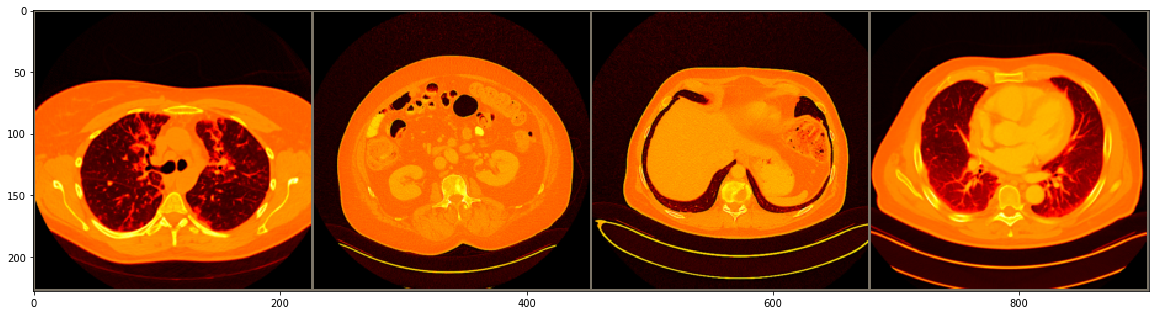

In [228]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    print(inp.numpy().shape)
    inp = inp.numpy().transpose((1, 2, 0))
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs, classes, bb = next(iter(dataloaders['train']))   

out = torchvision.utils.make_grid(inputs)
inputs
imshow(out)

In [3]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, bb in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                 # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [89]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
                     ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
                     ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

                     ]),
}

file_names = {'train': './train_set.tsv', 'val': './validation_set.tsv', 'test': './test_set.tsv'}

image_datasets = {x: DeepLesionDataset(file_names[x], '/media/mark/Data/deeplesion/Images_png',
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

dataset_sizes

{'train': 256, 'val': 32, 'test': 32}

In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
                     ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

                     ]),
}
# DeepLesionDataset('./test_set.tsv', '/media/mark/Data/deeplesion/Images_png')

file_names = {'train': './train_set.tsv', 'val': './validation_set.tsv', 'test': './test_set.tsv'}

image_datasets = {x: DeepLesionDataset(file_names[x], '/media/mark/Data/deeplesion/Images_png',
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
# class_names = image_datasets['train']['labels']



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 8)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.9374 Acc: 0.2695
val Loss: 1.5395 Acc: 0.4375

Epoch 1/24
----------
train Loss: 1.4149 Acc: 0.4922
val Loss: 1.2282 Acc: 0.5625

Epoch 2/24
----------
train Loss: 1.1203 Acc: 0.5820
val Loss: 1.2085 Acc: 0.4688

Epoch 3/24
----------
train Loss: 0.9077 Acc: 0.6836
val Loss: 1.8416 Acc: 0.5938

Epoch 4/24
----------
train Loss: 0.5346 Acc: 0.8398
val Loss: 1.4611 Acc: 0.5938

Epoch 5/24
----------
train Loss: 0.4174 Acc: 0.8711
val Loss: 1.6251 Acc: 0.5312

Epoch 6/24
----------
train Loss: 0.3522 Acc: 0.8906
val Loss: 1.4467 Acc: 0.6250

Epoch 7/24
----------
train Loss: 0.2494 Acc: 0.9219
val Loss: 1.1628 Acc: 0.7188

Epoch 8/24
----------
train Loss: 0.1316 Acc: 0.9766
val Loss: 1.1593 Acc: 0.7188

Epoch 9/24
----------
train Loss: 0.2212 Acc: 0.9492
val Loss: 1.1246 Acc: 0.7500

Epoch 10/24
----------
train Loss: 0.1986 Acc: 0.9414
val Loss: 1.1912 Acc: 0.7188

Epoch 11/24
----------
train Loss: 0.1375 Acc: 0.9688
val Loss: 1.0503 Acc: 0.8125

Ep

In [56]:
# This is the place we predict the disease from a model trained, output for this function is 
#the target values and probabilty of each image having a disease 
import torch.nn.functional as F
def inference(model_ft,loader):
    use_gpu = 1
    model_ft.eval()
    whole_output =[]
    whole_target = []

    for data, target, bb in loader:
#         print(data.type)
#         data = valData['x']
#         target = valData['y']
#         if use_gpu:
#             data = Variable(data,volatile=True).type(torch.FloatTensor).cuda()
#             target = Variable(target,volatile=True).type(torch.LongTensor).cuda()
#         else:
#             data, target = Variable(data,volatile=True).type(torch.FloatTensor), Variable(target,volatile=True).type(torch.LongTensor)
        data = data.to(device)
        target = target.to(device)
        output = F.softmax(model_ft(data))
#         output = model_ft(data)
        whole_output.append( output.cpu().data.numpy())
        whole_target.append( target.cpu().data.numpy())

    whole_output = np.concatenate(whole_output)
    whole_target = np.concatenate(whole_target)

    y_score = whole_output
    y_target = label_binarize(whole_target, classes=[0, 1, 2, 3, 4, 5, 6, 7])
    
    return y_score, y_target

# this function AUC of ROC for each disease seperately and also macro and micro averages,
# we will use macro average to compare different models we will train. 
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def get_AUC(y_score, y_target,plotROC=False):
    print(y_score.shape, y_target.shape)
    n_classes = y_score.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_target[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_target.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    if plotROC:
        lw = 2
        # Plot all ROC curves
        fig = plt.figure(figsize=(10, 10))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()

    return roc_auc

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(32, 8) (32, 8)


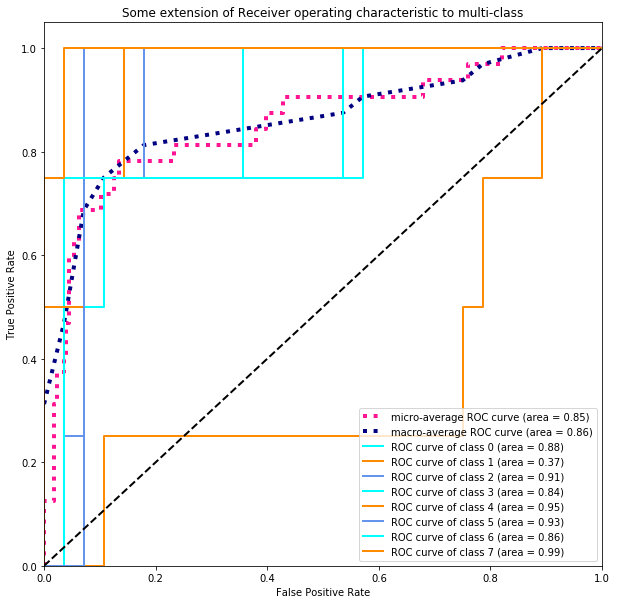

macro AUC for the model trained on full data is :  0.8604910714285715
Confusion matrix, without normalization
[[2 0 0 0 1 0 0 1]
 [0 0 0 1 0 3 0 0]
 [0 1 3 0 0 0 0 0]
 [0 1 0 3 0 0 0 0]
 [1 0 1 0 2 0 0 0]
 [0 0 0 0 0 4 0 0]
 [0 0 1 0 0 0 3 0]
 [0 1 0 0 0 0 0 3]]


<Figure size 432x288 with 0 Axes>

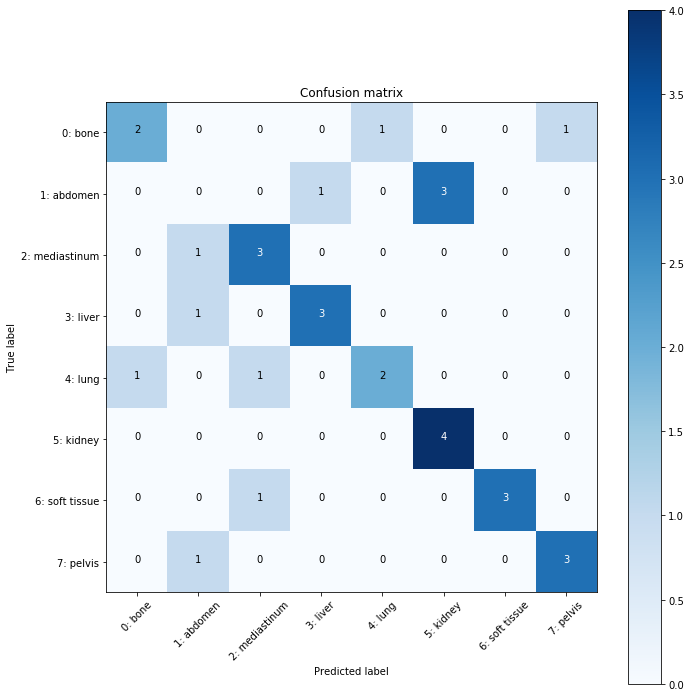

In [59]:
y_s, y_t=inference(model_ft,dataloaders['test'])
r_AUC_wholeSet = get_AUC(y_s, y_t,True)
print('macro AUC for the model trained on full data is : ', r_AUC_wholeSet['macro'])

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t.dot([0,1,2,3,4,5,6,7]), np.argmax(y_s,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = [
    '0: bone',
    '1: abdomen', # not in liver or kidney
    '2: mediastinum',
    '3: liver',
    '4: lung',
    '5: kidney',
    '6: soft tissue', # body wall,muscle, skin, fat, limbs, head, and neck
    '7: pelvis'    
]
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

In [129]:
# Code is taken from: https://github.com/thesemicolonguy/convisualize_nb/blob/master/cnn-visualize.ipynb 
# with minor modifications

def make_heatmap(image, true_class, model_hm, k=8, stride=8): 
    """
    Input image is of size (1, c, w, h) typically (1, 1, 224, 224) for our networks using x-rays
    true_class is a number corresponding to disease classes
    k in the filter size (c, k, k)
    """
    image = image.unsqueeze(0)
    data = image.to(device)
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
    
    # data transfrom to zero mean unit variance
#     image = (image - image.mean()) / image.std()
#     data = torch.autograd.Variable(torch.from_numpy(image),volatile=True).type(torch.FloatTensor).cuda()
    
    
    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.autograd.Variable(torch.ones(image.shape)).cuda()
            h_filter[:,:,j:j+k, i:i+k] = 0

            temp_image = data * h_filter
            temp_softmax = model_hm(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax,dim=1).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        i += stride
        a += 1
    
    image = image.squeeze()

    true_image = image.numpy().transpose(1, 2, 0)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    true_image = std * true_image + mean
    true_image = np.clip(true_image, 0, 1)
    
    # Plot both images
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    a.add_patch(patches.Rectangle((bbox['x'],bbox['y']),bbox['w'],bbox['h'],linewidth=1,edgecolor='w',facecolor='none'))
    plt.title('Original Image')
    plt.axis('off') 

        # Normalize heatmap
    heatmap = (heatmap - heatmap.min())/(heatmap.max() - heatmap.min())

    heatmap = np.uint8(255 * heatmap)
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap.transpose(1,  0))
    plt.title('Heatmap')
    plt.axis('off') 
    #plt.clim(0,1)
    plt.show()
    
    return heatmap

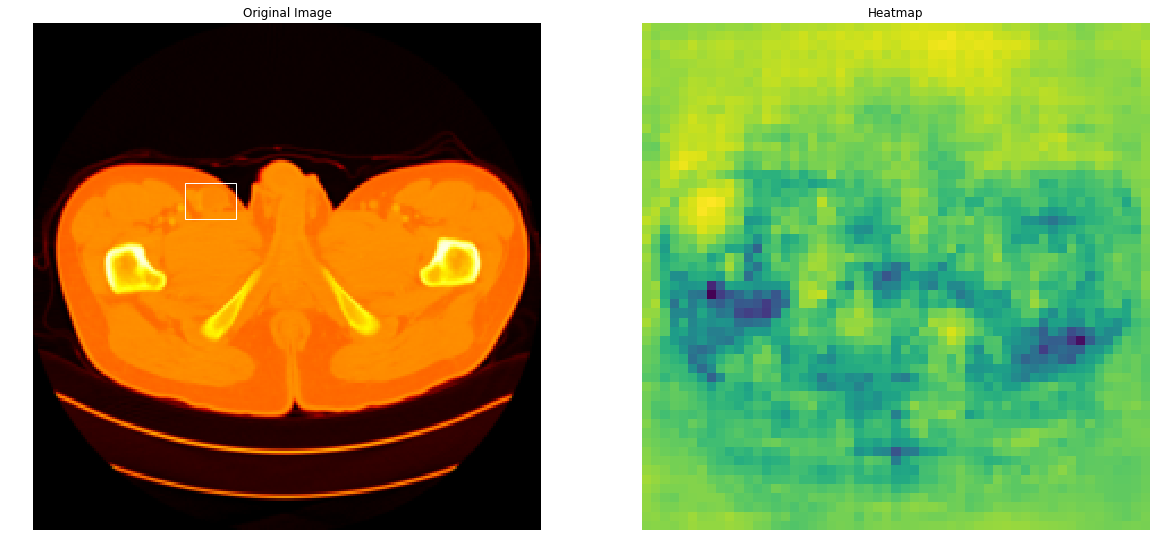

In [132]:
model_ft.eval()

for ddx in range(4):
#     img_name = os.path.join('images', df.iloc[ddx, 0])
#     bbox= {'x':df.iloc[ddx,2],'y':df.iloc[ddx,3],'w':df.iloc[ddx,4],'h':df.iloc[ddx,5]}
#     print(df.iloc[ddx,0],df.iloc[ddx,1],bbox)
    inputs, classes, bb = next(iter(dataloaders['test']))  
    for samp_idx in range(4):
        bbox= {
            'x':bb.cpu().numpy()[samp_idx][0][0] / (16/7),
            'y':bb.cpu().numpy()[samp_idx][0][1] / (16/7),
            'w':(bb.cpu().numpy()[samp_idx][1][0] - bb.cpu().numpy()[samp_idx][0][0]) / (16/7),
            'h':(bb.cpu().numpy()[samp_idx][1][1] - bb.cpu().numpy()[samp_idx][0][1]) / (16/7)}

    #     image = io.imread(img_name)
    #     image = image[np.newaxis,np.newaxis,:]

    #     if df.iloc[ddx,1] == 'Infiltrate':
    #         true_class = 1
    #     elif df.iloc[ddx,1] == 'Pneumothorax':
    #         true_class = 2
    #     elif df.iloc[ddx,1] == 'Cardiomegaly':
    #         true_class = 3
    #     else:
    #         true_class = 0

    #     heatmap = make_heatmap(image, true_class, model_ft, k=64, stride=8 )
        heatmap = make_heatmap(inputs[samp_idx], classes[samp_idx], model_ft, k=8, stride=4 )
        break
    break

In [145]:
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

In [223]:
from torch.autograd import Variable
def make_saliency_map(input, label, model):
#     input = Variable(preprocess(input).unsqueeze(0).cuda(), requires_grad=True)
    input = Variable(input.unsqueeze(0).to(device), requires_grad=True)
    output = model(input)
    output[0][label].backward()
    grads = input.grad.data.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    true_image = input.data
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    a.add_patch(patches.Rectangle((bbox['x'],bbox['y']),bbox['w'],bbox['h'],linewidth=1,edgecolor='w',facecolor='none'))

    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off') 
    plt.title('Saliency Map')
    
    return grads

In [222]:
from PIL import Image

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])

def smooth_grad(input, label, model, x=10, percent_noise=10):
    """
    The apparent noise one sees in a sensitivity map may be due to 
    essentially meaningless local variations in partial derivatives.
    After all, given typical training techniques there is no reason to expect derivatives to vary smoothly.
    """
    tensor_input = torch.from_numpy(np.array(input)).type(torch.cuda.FloatTensor) # input is now of shape (w,h,c)
    # x is the sample size
    final_grad = torch.zeros((1,3,224,224)).cuda()
    for i in range(x):
        print('Sample:', i+1)
        temp_input = tensor_input
        # According to the paper, noise level corrresponds to stddev/(xmax-xmin). Hence stddev = noise_percentage * (max-min) /100
        noise = torch.from_numpy(np.random.normal(loc=0, scale=(percent_noise/100) * (tensor_input.max() - tensor_input.min()), size=temp_input.shape)).type(torch.cuda.FloatTensor)
        temp_input = (temp_input + noise).cpu().numpy()
        temp_input = Image.fromarray(temp_input.astype(np.uint8).transpose(1,2,0))
        temp_input = Variable(preprocess(temp_input).unsqueeze(0).cuda(), requires_grad=True)
        output = model(temp_input)
        output[0][label].backward()
        final_grad += temp_input.grad.data
    
    grads = final_grad/x
    grads = grads.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
   
    true_image = input.numpy().transpose(1, 2, 0)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    true_image = std * true_image + mean
    true_image = np.clip(true_image, 0, 1)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    a.add_patch(patches.Rectangle((bbox['x'],bbox['y']),bbox['w'],bbox['h'],linewidth=1,edgecolor='w',facecolor='none'))

    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off')  
    plt.title('SmoothGrad, Noise: ' + str(percent_noise) + '%, ' + 'Samples: ' + str(x))
    
    return grads

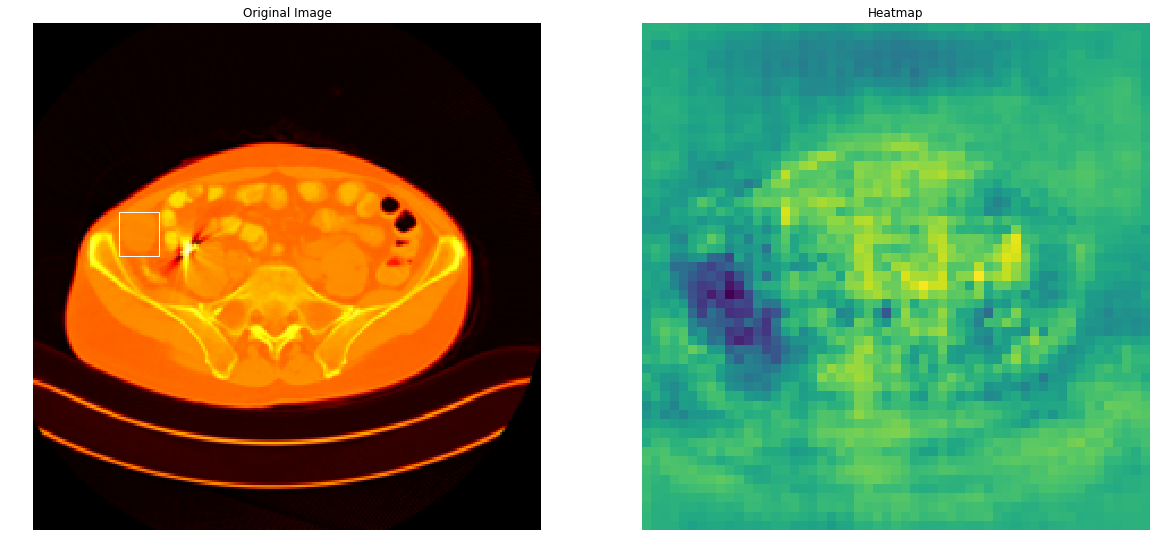

Sample: 1
Sample: 2
Sample: 3
Sample: 4
Sample: 5
Sample: 6
Sample: 7
Sample: 8
Sample: 9
Sample: 10
Sample: 11
Sample: 12
Sample: 13
Sample: 14
Sample: 15
Sample: 16
Sample: 17
Sample: 18
Sample: 19
Sample: 20
Sample: 21
Sample: 22
Sample: 23
Sample: 24
Sample: 25
Sample: 26
Sample: 27
Sample: 28
Sample: 29
Sample: 30


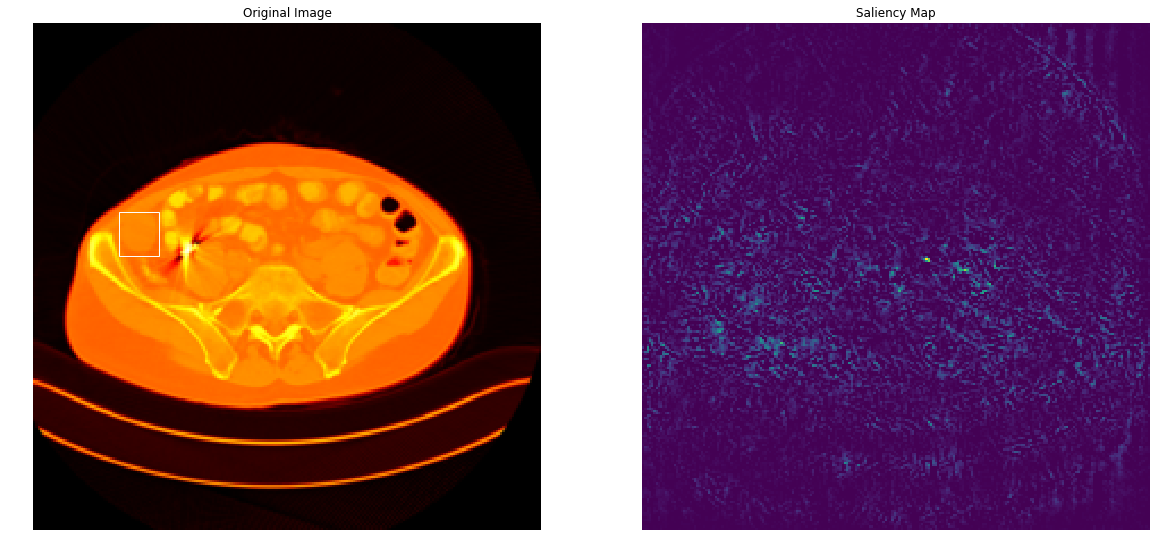

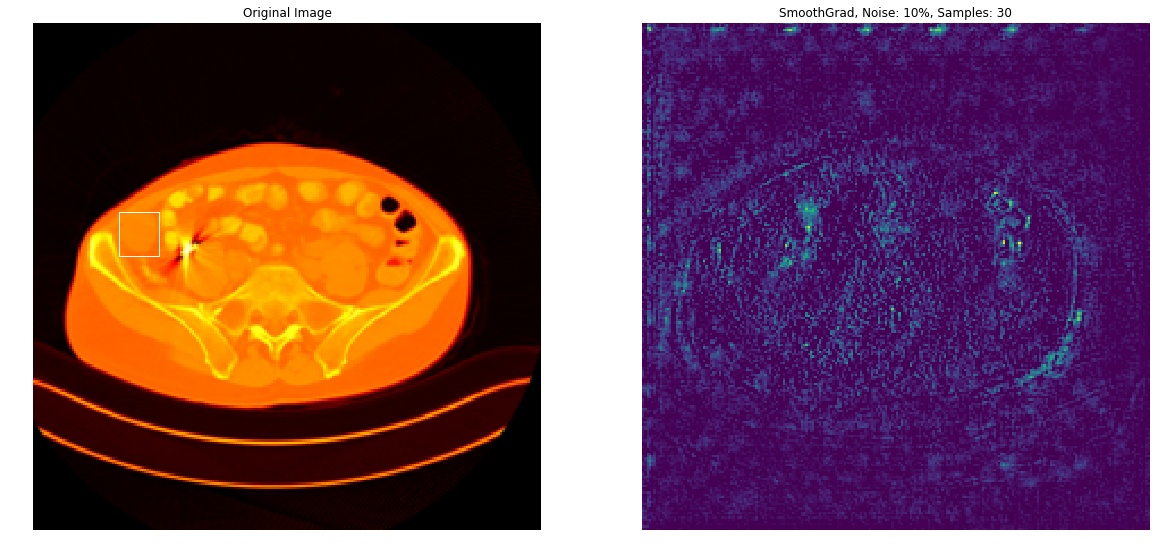

In [226]:
model_ft.eval()

for ddx in range(4):
#     img_name = os.path.join('images', df.iloc[ddx, 0])
#     bbox= {'x':df.iloc[ddx,2],'y':df.iloc[ddx,3],'w':df.iloc[ddx,4],'h':df.iloc[ddx,5]}
#     print(df.iloc[ddx,0],df.iloc[ddx,1],bbox)
    inputs, classes, bb = next(iter(dataloaders['test']))  
    for samp_idx in range(4):
        bbox= {
            'x':bb.cpu().numpy()[samp_idx][0][0] / (16/7),
            'y':bb.cpu().numpy()[samp_idx][0][1] / (16/7),
            'w':(bb.cpu().numpy()[samp_idx][1][0] - bb.cpu().numpy()[samp_idx][0][0]) / (16/7),
            'h':(bb.cpu().numpy()[samp_idx][1][1] - bb.cpu().numpy()[samp_idx][0][1]) / (16/7)}

        heatmap = make_heatmap(inputs[samp_idx], classes[samp_idx], model_ft, k=8, stride=4 )
        make_saliency_map(inputs[samp_idx], classes[samp_idx], model_ft)
        smooth_grad(inputs[samp_idx], classes[samp_idx], model_ft, 30, 10)
        break
    break 
